## Image segmentation with CamVid

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [5]:
# path = untar_data(URLs.CAMVID)
# path.ls()
path = Path('/projects/da_workspace/szspace/.fastai/data/camvid')

In [6]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [ ]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [16]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/projects/da_workspace/szspace/.fastai/data/camvid/images/0006R0_f02280.png'),
 PosixPath('/projects/da_workspace/szspace/.fastai/data/camvid/images/0006R0_f02130.png'),
 PosixPath('/projects/da_workspace/szspace/.fastai/data/camvid/images/Seq05VD_f04380.png')]

In [17]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/projects/da_workspace/szspace/.fastai/data/camvid/labels/0001TP_008970_P.png'),
 PosixPath('/projects/da_workspace/szspace/.fastai/data/camvid/labels/Seq05VD_f02550_P.png'),
 PosixPath('/projects/da_workspace/szspace/.fastai/data/camvid/labels/0016E5_06120_P.png')]

In [18]:
# import PIL
# open_image??
# PIL.Image.open??

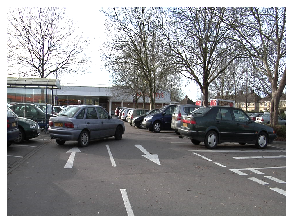

In [19]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [20]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [21]:
img_f
img_f.stem
img_f.suffix

PosixPath('/projects/da_workspace/szspace/.fastai/data/camvid/images/0006R0_f02280.png')

'0006R0_f02280'

'.png'

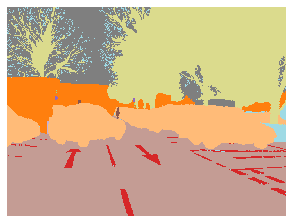

In [22]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [23]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [24]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [25]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11836MB of GPU RAM free


In [26]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [27]:
bs=4 # manually set here for now

In [28]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

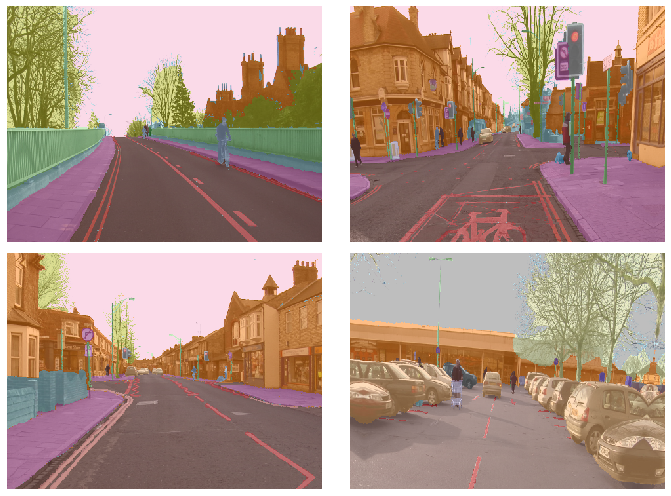

In [29]:
data.show_batch(2, figsize=(10,7))

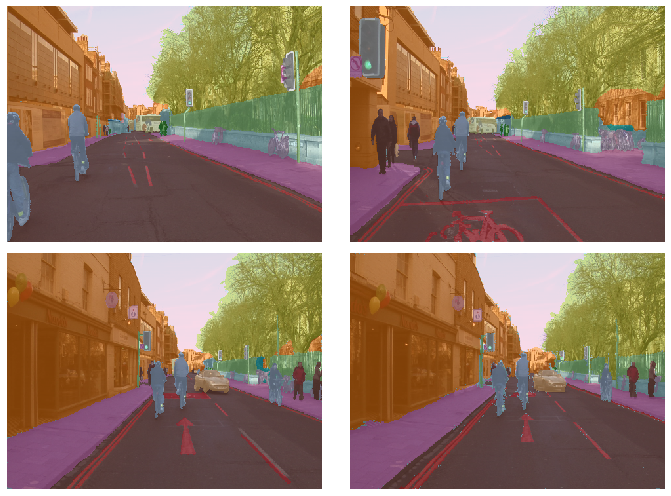

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [30]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [31]:
metrics=acc_camvid
# metrics=accuracy

In [32]:
wd=1e-2

In [33]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [24]:
# with torch.cuda.device(3):
#     print(torch.cuda.is_available())
#     print(torch.cuda.current_device())

In [73]:
#  !nvidia-smi --query-gpu=timestamp,pstate,temperature.gpu,utilization.gpu,utilization.memory,memory.total,memory.free,memory.used --format=csv -l 
# !nvidia-smi --query-gpu=timestamp,memory.used,memory.total --format=csv -l 1

True
0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


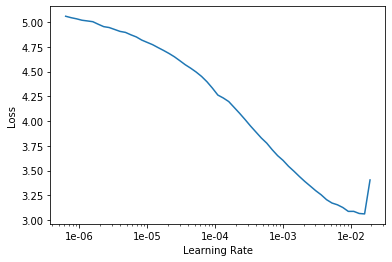

In [25]:
with torch.cuda.device(0):
    print(torch.cuda.is_available())
    print(torch.cuda.current_device())
lr_find(learn)
learn.recorder.plot()

In [26]:
lr=3e-3

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.244844,0.861693,0.805407,01:34
1,0.837963,0.636536,0.834600,01:32
2,0.709415,0.603835,0.842120,01:32
3,0.656411,0.547927,0.852831,01:32
4,0.592909,0.552160,0.834978,01:37
5,0.609105,0.468826,0.864071,01:32
6,0.569072,0.464412,0.867705,01:32
7,0.573604,0.459379,0.872331,01:32
8,0.524392,0.416724,0.889533,01:32
9,0.458735,0.329681,0.909038,01:32


In [28]:
learn.save('stage-1')

In [29]:
learn.load('stage-1');

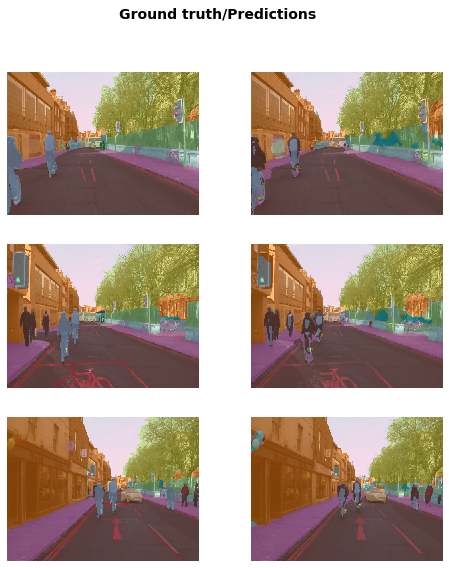

In [30]:
learn.show_results(rows=3, figsize=(8,9))

In [31]:
learn.unfreeze()

In [32]:
lrs = slice(lr/400,lr/4)

In [33]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.392174,0.322491,0.907895,01:35
1,0.379034,0.320875,0.908094,01:35
2,0.367911,0.303602,0.916075,01:35
3,0.356424,0.295455,0.920512,01:35
4,0.345189,0.303179,0.915943,01:35
5,0.341572,0.304811,0.918940,01:35
6,0.333700,0.294338,0.918337,01:35
7,0.320956,0.274146,0.927980,01:36
8,0.319445,0.310104,0.917713,01:39
9,0.308306,0.298336,0.914479,01:35


In [34]:
learn.save('stage-2');

In [34]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /projects/da_workspace/szspace/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /projects/da_workspace/szspace/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [35]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 11836MB of GPU RAM free


In [36]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [37]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [38]:
learn.load('stage-2');

In [39]:
lr_find(learn)
learn.recorder.plot()

RuntimeError: CUDA out of memory. Tried to allocate 9.00 MiB (GPU 0; 11.93 GiB total capacity; 9.75 GiB already allocated; 4.12 MiB free; 8.83 MiB cached)

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

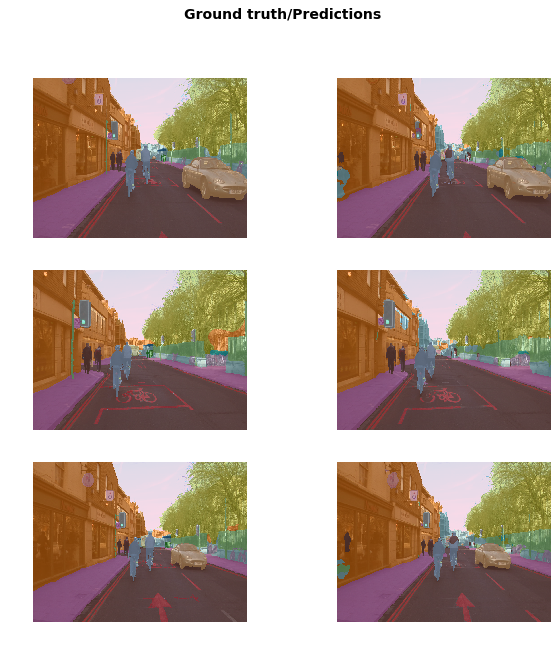

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

In [74]:
DataBunch??

## fin